<a href="https://colab.research.google.com/github/OlgaPuntous/NLP-deep-learning-Disaster-tweeets-dataset-Kaggle/blob/master/Disaster_Tweets_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hello 

This is an NLP example notebook, were we are going to use Kaggle dataset 'Natural Language Processing with Disaster Tweets' 

In this kaggle competition, the challenge is to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. So, it's binary classification problem.

Let's start importing the libraries:

In [31]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib 
import pandas as pd 
import numpy as np
import spacy

In [32]:
from textblob import TextBlob #will be testing Textblob library for text correction

In [33]:
nlp = spacy.load("en")

In [34]:
from spacy.lang.en.stop_words import STOP_WORDS

# Looking at dataset
Let's make a quick look at our dataset.

In [35]:
data=pd.read_csv('/content/drive/MyDrive/train.csv')
data.sample(5)

,id,keyword,location,text,target
6101,8711,sinking,NaN,We walk the plank of a sinking ship,0
6035,8625,seismic,NaN,#Sismo DETECTADO #JapÌ_n [Report 3] 01:02:17 O...,1
6768,9699,tornado,canada,Calgary area tornado warnings end as thunderst...,1
4057,5764,forest%20fires,NaN,A group of Florida Forest Service firefighters...,1
2006,2882,damage,"Pontevedra, Galicia",#NP Metallica - Damage Inc,0


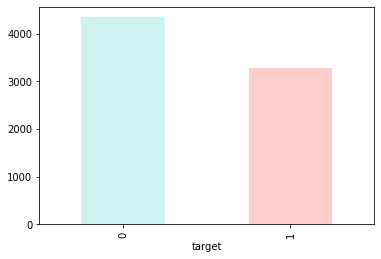

In [36]:
data.groupby(['target']).count()['id'].plot.bar(color=['c','r'],alpha=0.2)


This is initial distribution of our target. There are more non-disaster tweets than disaster.

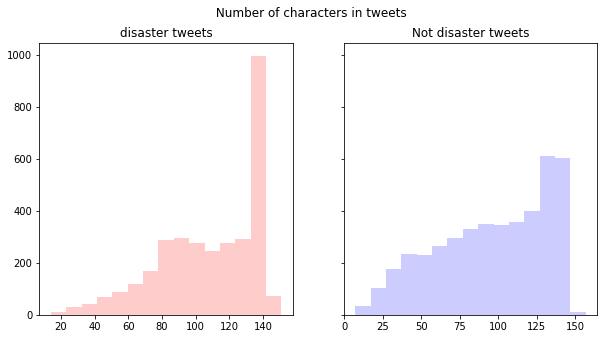

In [37]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5),sharey=True)

tweet_len=data[data['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='r',alpha=0.2,bins=15)
ax1.set_title('disaster tweets')
tweet_len=data[data['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='b',alpha=0.2,bins=15)
ax2.set_title('Not disaster tweets')
fig.suptitle(' Number of characters in tweets')
plt.show()

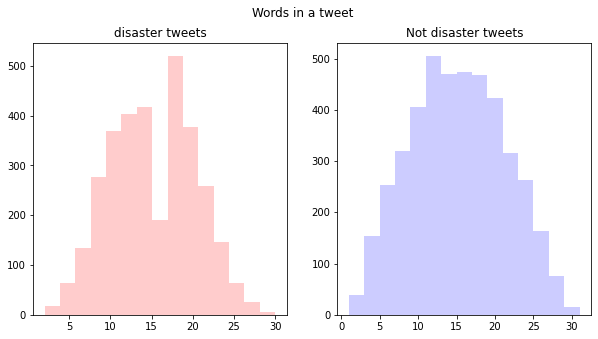

In [38]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=data[data['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='r',alpha=0.2,bins=15)
ax1.set_title('disaster tweets')
tweet_len=data[data['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='b', alpha=0.2,bins=15)
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

What we see from visualisations, that disaster tweets ans non-disaster tweets have pretty similar distrubutions by number of characters and words length.

# Data preprocessing

First , we need to clean the text of our tweets from internel links, email adresses , punctuation,

In [39]:
def cleaning(df):

    df =df.str.replace(r'http\S+', " ") #removing internet links from text 
    df =df.str.replace(r"\S*@\S*\s?",' ')#removing email adresses from text 
    df = df.str.replace('[^\w\s]',' ')#keeping only alphanumeric characters
    df = df.str.replace("#", " ")#converting tags to text
    df = df.str.replace('\d+', '')#removing digits from text
    df = df.str.replace(" +", " ")

    return (df)

In [40]:
data['clean_text']=cleaning(data['text'])
data['clean_location'] =cleaning(data['location'])
data['clean_keyword'] =cleaning(data['keyword'])


a=np.random.randint(6000)
print('\033[1m'+'initial text:'+'\033[0m')
print(data.loc[a,'text'])
print('\033[1m'+'clean_text:'+'\033[0m')
print(data.loc[a,'clean_text'])
print('...')


print('\033[1m'+'initial_location:'+'\033[0m')
print(data.loc[a,'location'])
print('\033[1m'+'clean text:'+'\033[0m')
print(data.loc[a,'clean_location'])
print('...')


print('\033[1m'+'initial_keyword:'+'\033[0m')
print(data.loc[a,'keyword'])
print('\033[1m'+'clean_keyword:'+'\033[0m')
print(data.loc[a,'clean_keyword'])
print('...')




initial text:
09:13 PM:  Hazardous Weather Outlook (http://t.co/ed1VpITsWY): NO HAZARDOUS WEATHER IS EXPECTED AT THIS TIME.... http://t.co/6XSbddlZiy
clean_text:
 PM Hazardous Weather Outlook NO HAZARDOUS WEATHER IS EXPECTED AT THIS TIME 
...
initial_location:
Gainesville, FL
clean text:
Gainesville FL
...
initial_keyword:
hazardous
clean_keyword:
hazardous
...


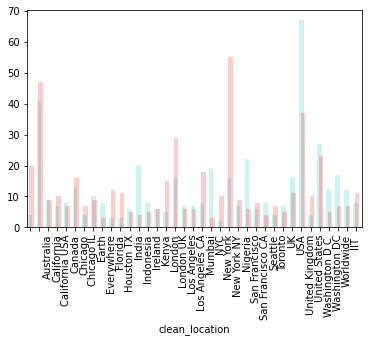

In [41]:
ax=data[data['target']==1].groupby(['clean_location']).count()['id'][data.groupby(['clean_location']).count()['id']>10].plot.bar(color=['c'],alpha=0.2)
ax=data[data['target']==0].groupby(['clean_location']).count()['id'][data.groupby(['clean_location']).count()['id']>10].plot.bar(color=['r'],alpha=0.2,position=0.2)

In this model I've decided not to use location.

In [42]:
data['clean_text']=data['clean_text'].astype(str)
data['clean_text']=data['clean_text'].apply(lambda x: TextBlob(str(x))) #correcting grammar,not sure its works perfectly
print(data.loc[a	,'clean_text'])

 PM Hazardous Weather Outlook NO HAZARDOUS WEATHER IS EXPECTED AT THIS TIME 


In [43]:
data_cleaned=data.drop(columns=['id','keyword','location','text','clean_location'],axis=0)

In [44]:
data_cleaned=data_cleaned.sample(len(data_cleaned))


In [45]:
def lemmatize_text(text): #need to lemmatize the text before converting it to the vectors.
  text = ''.join(ch for ch in text if ch.isalnum() or ch==" ")
  text = text.replace(" +"," ").lower().strip()
  text=nlp(text)
  lemma = ' '.join([token.lemma_ for token in text if token.lemma_ not in STOP_WORDS])
  return lemma

In [46]:
data_cleaned[["text_lemma"]] = data_cleaned["clean_text"].apply(lambda x: lemmatize_text(str(x)))
data_cleaned[["clean_keyword_lemma"]] = data_cleaned["clean_keyword"].apply(lambda x: lemmatize_text(str(x)))

In [47]:
data_cleaned["text_lemma"]=data_cleaned["text_lemma"].str.split().map(lambda x: " ".join(s for s in x if len(s) > 2)) # cleaning all words >2 letters by in case
data_cleaned=data_cleaned.drop(columns=['clean_text','clean_keyword'], axis=1)

data_cleaned.sample(5)


,target,text_lemma,clean_keyword_lemma
482,0,-PRON- dog attack -PRON- -PRON- food pugprobs,attack
7578,0,wreck -PRON-,wreck
2470,1,modiministry railway minister prabhu derailmen...,derailment
77,1,traffic accident cabrillo hwy magellan mir,accident
2656,0,apollo brown detonate,detonate


In [48]:
tokenizer = tf.keras.preprocessing.text.Tokenizer() #creating tokenizer
tokenizer.fit_on_texts(data_cleaned['text_lemma'])
vocabulary_size=len(tokenizer.word_index)
vocabulary_size

11656

In [49]:
data_cleaned["encoded"] = tokenizer.texts_to_sequences(data_cleaned['text_lemma'])#converting text to vector
data_cleaned["encoded_keyword"]  = tokenizer.texts_to_sequences(data_cleaned['clean_keyword_lemma'])

data_cleaned.head()

,target,text_lemma,clean_keyword_lemma,encoded,encoded_keyword
6177,1,bomb squad car head north elliott siren word -...,siren,"[13, 1193, 42, 130, 457, 3339, 166, 279, 1, 130]",[166]
2100,0,like video hazard death sport,death,"[2, 12, 237, 39, 817]",[39]
5891,1,watch airport swallow sandstorm minute,sandstorm,"[37, 387, 356, 290, 228]",[290]
5993,0,scream don scare -PRON- -PRON- animatronic,scream,"[44, 8, 818, 1, 1, 4895]",[44]
5692,1,rescue med migrant arrive sicily migrant rescue,rescue,"[68, 869, 195, 675, 1613, 195, 68]",[68]


In [92]:
padded_ecoded_text = tf.keras.preprocessing.sequence.pad_sequences(data_cleaned["encoded"], padding="post")

In [93]:
padded_ecoded_keyword = tf.keras.preprocessing.sequence.pad_sequences(data_cleaned["encoded_keyword"], padding="post")
padded_ecoded_keyword.shape

(7613, 2)

In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_v = TfidfVectorizer(max_df=0.9, min_df=0.01, max_features=1000)

tfidf_data = tfidf_v.fit_transform(data_cleaned["text_lemma"])

In [95]:
tfidf_data = tfidf_data.todense()

In [96]:
full_ds_model = tf.data.Dataset.from_tensor_slices((padded_ecoded_text, padded_ecoded_keyword, tfidf_data, data_cleaned["target"]))

In [97]:
train_data = full_ds_model.shuffle(int(data_cleaned.shape[0]))

In [98]:
padded_ecoded_text.shape

(7613, 23)

In [99]:
vocab_size_keyword=0
for x in range(0,len(data_cleaned.encoded_keyword)):
    vocab_size_keyword+=len(data_cleaned.encoded_keyword[x])

vocab_size_keyword

8643

In [100]:
for  tweet,keyword,tfidf_sample, target in train_data.take(1):
        print (keyword.shape[0])

2


In [101]:
vocab_size=len(tokenizer.index_word)
vocab_size

11656

# Creating customazed model with three inputs: encoded padded text, itd tf-idf matrix, keyword vector


In [102]:
# model for sequences

emb1 = tf.keras.layers.Embedding(vocab_size+1, 256, input_length=[tweet.shape[0]])
lstm1 = tf.keras.layers.LSTM(256, return_sequences=True)
lstm2 = tf.keras.layers.LSTM(128, return_sequences=False)
dropout_tweet = tf.keras.layers.Dropout(0.3)
dropout_tfidf = tf.keras.layers.Dropout(0.3)

# model for keyword data
emb2 = tf.keras.layers.Embedding(vocab_size_keyword+1, 4, input_length=[keyword.shape[0]])
fl=tf.keras.layers.Flatten()
bn_keyword = tf.keras.layers.BatchNormalization()
dense_keyword = tf.keras.layers.Dense(128, activation="relu",kernel_regularizer="l1")


# model for tfidf
dense_tfidf = tf.keras.layers.Dense(32, activation="relu",kernel_regularizer="l1")


# model concatenated data
dense_concat = tf.keras.layers.Dense(128, activation="relu",kernel_regularizer="l1")
dense_after_concat=tf.keras.layers.Dense(32, activation="relu",kernel_regularizer="l1")
dense_pred = tf.keras.layers.Dense(1, activation="sigmoid",kernel_regularizer="l1")
dropout_after_concat = tf.keras.layers.Dropout(0.5)

In [103]:
keyword.shape[0]

2

In [104]:
input_text = tf.keras.Input(shape = [tweet.shape[0]], name="tweets")
input_keyword = tf.keras.Input(shape=[keyword.shape[0]], name="keyword")
input_tfidf = tf.keras.Input(shape=[tfidf_sample.shape[0]], name="tfidf")


text = emb1(input_text)
text = lstm1(text)
text = lstm1(text)
text = lstm2(text)
text = dropout_tweet(text)

keyword = emb2(input_keyword)
keyword=fl(keyword)
keyword = bn_keyword(keyword)
keyword = dense_keyword(keyword)

tfidf_output = dense_tfidf(input_tfidf)
tfidf_output = dropout_tfidf(tfidf_output)

concat = tf.keras.layers.Concatenate()([text,keyword,tfidf_output])

concat = dense_concat(concat)
concat=dropout_after_concat(concat)
dense_aft_concat=dense_after_concat(concat)
pred = dense_pred(dense_aft_concat)

In [105]:
model = tf.keras.Model(inputs=[input_text,input_keyword,input_tfidf], outputs=pred)

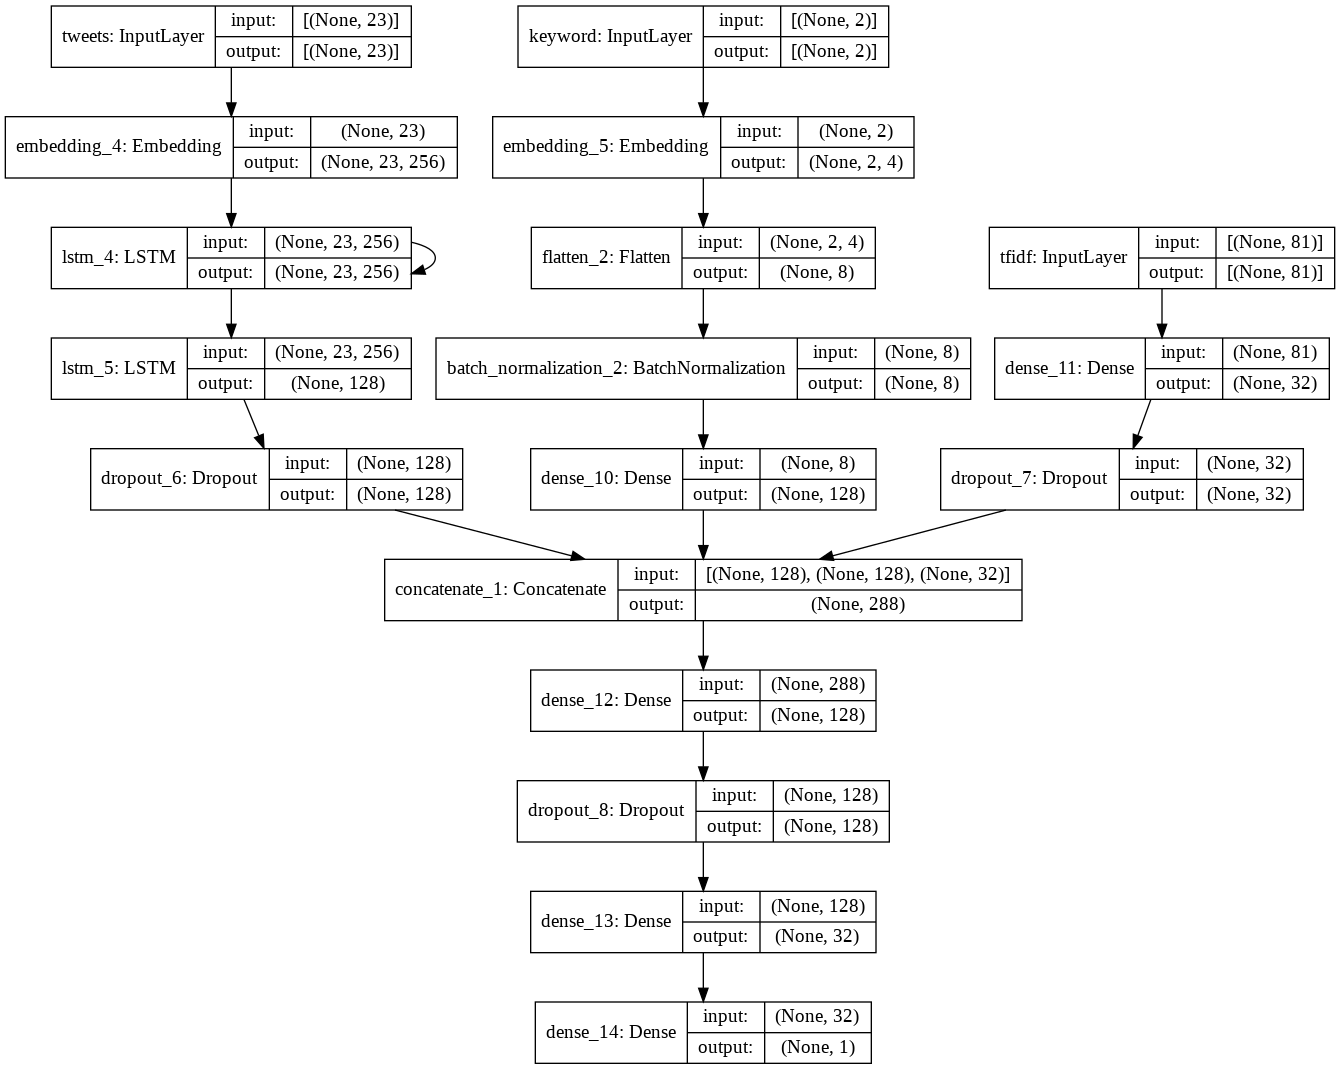

In [106]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [107]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)



In [108]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [109]:
model.fit(x={"tweets": padded_ecoded_text,
             "keyword": padded_ecoded_keyword,
             "tfidf": tfidf_data},
          y=data_cleaned['target'],
          validation_split = 0.3,
          batch_size = 32,
          epochs=20)

Epoch 1/20
167/167 [==============================] - 58s 317ms/step - loss: 29.1401 - binary_accuracy: 0.5666 - val_loss: 23.9100 - val_binary_accuracy: 0.7496
Epoch 2/20
167/167 [==============================] - 52s 310ms/step - loss: 22.2917 - binary_accuracy: 0.7865 - val_loss: 17.8722 - val_binary_accuracy: 0.7920
Epoch 3/20
167/167 [==============================] - 52s 310ms/step - loss: 16.4357 - binary_accuracy: 0.8914 - val_loss: 12.9049 - val_binary_accuracy: 0.7942
Epoch 4/20
167/167 [==============================] - 52s 310ms/step - loss: 11.6461 - binary_accuracy: 0.9262 - val_loss: 8.9608 - val_binary_accuracy: 0.7544
Epoch 5/20
167/167 [==============================] - 52s 311ms/step - loss: 7.8474 - binary_accuracy: 0.9439 - val_loss: 5.9257 - val_binary_accuracy: 0.7557
Epoch 6/20
167/167 [==============================] - 52s 310ms/step - loss: 4.9982 - binary_accuracy: 0.9600 - val_loss: 3.7711 - val_binary_accuracy: 0.7732
Epoch 7/20
167/167 [===================

# Nouvelle section

# Nouvelle section